# Lecture IX: Solving Ordinary Differential Equations (ODE)

This lecture is mainly from "Numerical Recipes in C" (cap. 17, or 16 in older editions). The older versions of this textbook are freely available. Codes reported from the textbook are copytight of them.


Problems involving ordinary differential equations (ODEs) can always be reduced to the study of sets of first order differential equations. For example the second-order equation

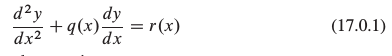

can be rewritten as two first-order equations,

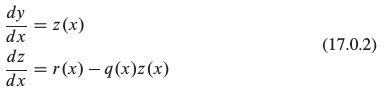

where z is a new variable. This exemplifies the procedure for an arbitrary ODE. The usual choice for the new variables is to let them be just derivatives of each other (and of the original variable). Occasionally, it is useful to incorporate into their definition some other factors in the equation, or some powers of the independent variable, for the purpose of mitigating singular behavior that could result in overflows or increased roundoff error. Let common sense be your guide: If you find that the original variables are smooth in a solution, while your auxiliary variables are doing crazy things, then figure out why and choose different auxiliary variables.

The generic problem in ordinary differential equations is thus reduced to the study of a set of N coupled first-order differential equations for the functions $y_i$: 

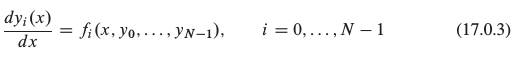

where the functions $f_i$ on the right-hand side are known.


A problem involving ODEs is not completely specified by its equations. Even more crucial in determining how to attack the problem numerically is the nature of the problem’s boundary conditions. 
**Boundary conditions are algebraic conditions on the values of the functions $y_i$ in (17.0.3).**

In general they can be satisfied at discrete specified points, but do not hold between those points, i.e., are not preserved automatically by the differential equations. Boundary conditions can be as simple as requiring that certain variables have certain numerical values, or as complicated as a set of nonlinear algebraic equations among the variables.


Usually, it is the nature of the boundary conditions that determines which numerical methods will be feasible. Boundary conditions divide into two broad categories.

- In initial value problems all the yi are given at some starting value xs , and it is desired to find the $y_i$ ’s at some final point $x_f$ , or at some discrete list of points (for example, at tabulated intervals).
- In two-point boundary value problems, on the other hand, boundary conditions are specified at more than one x. Typically, some of the conditions will be specified at $x_s$ and the remainder at $x_f$.

Here we only treat initial value problems.


There are a number of numerical methods to solve ODE. A general purpose, efficient one is the **Runge-Kutta** method, that is also the most used in _normal_  ODE integration codes in physics.

*Runge-Kutta methods propagate a solution over an interval by combining the information from several **Euler-style steps** (each involving **one evaluation of the right-hand f ’s**), and then using the information obtained to match a Taylor series expansion up to some higher order.*



## Runge-Kutta method

The formula for the Euler method is

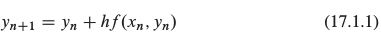

which advances a solution from $x_n$ to $x_{n+1} ~ x_n+h$. 

The formula is **unsymmetrical**: It advances the solution through an interval h, but uses derivative information only at the beginning of that interval (see Figure 17.1.1). That means (and you can verify by expansion in power series) that the step’s error is only one power of h smaller than the correction, i.e., $O(h^2)$  added to (17.1.1).

There are several reasons that Euler’s method is not recommended for practical use, among them
- the method is not very accurate when compared to other, fancier, methods run at the equivalent stepsize, and 
- neither is it very stable

Note that the Euler method is simply a discretization of the time derivative definition (the incremental ratio).

Consider, however, the use of a step like (17.1.1) to take a “trial” step to the midpoint of the interval. Then use the values of both x and y at that midpoint to compute the “real” step across the whole interval. Figure 17.1.2 illustrates the idea.

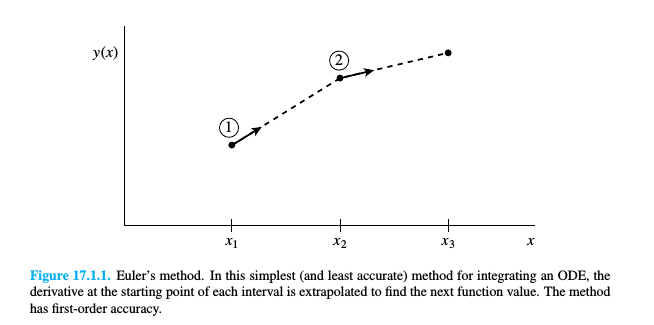

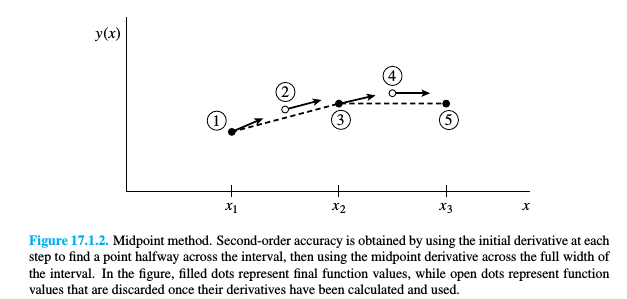


In equations,

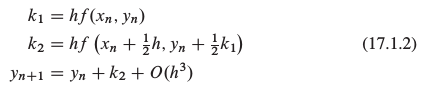

As indicated in the error term, this symmetrization cancels out the first-order error term, making the method second order. [A method is conventionally called $n^{\rm th}$ order if its error term is $O(h^{n+1)}$] In fact, (17.1.2) is called the **second-order Runge-Kutta** or **midpoint method**.

**Note: the so-called *leap-frog* integrator is equivalent to a $2^{nd}$ order *in velocities* RK integration.** We will use it in the rest of our course.

<hr>
<hr>


**Exercize 1**: Write a midpoint integrator and apply it to solving the followind ODE:

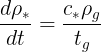

Integrate if for $2 t_g$ and write output each $1/5 t_g$.
How do you chose the integration interval h? How do the accuracy of solution and the computing time vary with h?

This is the simplest possible *star formation law* given a gas density $\rho_g$, a time consumption of gas $t_g$ and a star formation efficiency $c_*$. Use $c_*=0.02$, $\rho_g=10 M_{\rm sol}/kpc^3$ **constant**, $t_g = 1.5$ Gyr. Note that
- keeping $\rho_g$ constant physically means that the gas is replenished while it form stars!
- this equation is analitically integrable and its solution is: 


note the boundary conditions $t_0=0$, $\rho_{*,0}=0$

You can use it to test your integration. How the accuracy depend on h? Why?

- What would change if the law were

?

What is the impact of the size of h, now?

- If we do not suppose the gas to be replenished, a second, couple ODE for the gas is simply $d\rho_g/dt = - d\rho_*/dt$ . At home, modify your code to integrate these two equations togheter (coupled system). What is changing now?




## Higher orders

We needn’t stop there. There are many ways to evaluate the right-hand side `f(x,y)` that all agree to first order, but that have different coefficients of higher-order error terms. Adding up the right combination of these, we can eliminate the error terms order by order. That is the basic idea of the Runge-Kutta method. Abramowitz and Stegun and Gear give various specific formulas that derive from this basic idea. By far the most often used is the **classical fourth-order Runge-Kutta formula**

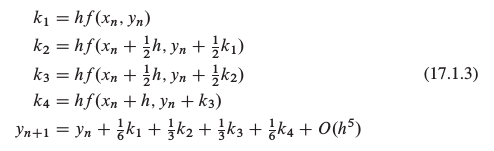

The fourth-order Runge-Kutta method requires four evaluations of the right- hand side per step h (see Figure 17.1.3). This will be superior to the midpoint method (17.1.2) if at least twice as large a step is possible with (17.1.3) for the same accuracy. Is that so? The answer is: often, perhaps even usually, but surely not always! 

This takes us back to a central theme, namely that high order does not always mean high accuracy. The statement “fourth-order Runge-Kutta is generally superior to second-order” is a true one, but as much a statement about the kind of problems that people solve as a statement about strict mathematics.

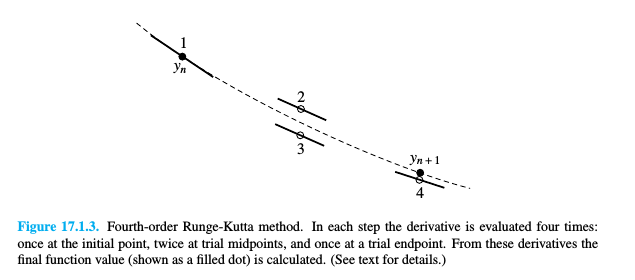

Here you have the core of RK4 integrator from the Numerical:



In [ ]:
#include "nrutil.h"
void rk4( float y[], float dydx[], int n, float x, float h, float yout[],
void (*derivs)(float, float [], float []) )

/*Given values for the variables y[1..n] and their derivatives dydx[1..n] known at x, use the
fourth-order Runge-Kutta method to advance the solution over an interval h and return the
incremented variables as yout[1..n], which need not be a distinct array from y. The user
supplies the routine derivs(x,y,dydx), which returns derivatives dydx at x. */
{
int i;
float xh,hh,h6,*dym,*dyt,*yt;
dym=vector(1,n);
dyt=vector(1,n);
yt=vector(1,n);
hh=h*0.5;
h6=h/6.0;
xh=x+hh;
for (i=1;i<=n;i++) yt[i]=y[i]+hh*dydx[i]; /* First step.  */
(*derivs)(xh,yt,dyt);                     /* Second step. */
for (i=1;i<=n;i++) yt[i]=y[i]+hh*dyt[i];
(*derivs)(xh,yt,dym);                     /* Third step.  */
for (i=1;i<=n;i++) 
    {
     yt[i]=y[i]+h*dym[i];
     dym[i] += dyt[i];
    }
(*derivs)(x+h,yt,dyt);                    /* Fourth step. */
for (i=1;i<=n;i++)                        /*  Accumulate increments with proper */
    yout[i]=y[i]+h6*(dydx[i]+dyt[i]+2.0*dym[i]); /* weights. */
free_vector(yt,1,n);
free_vector(dyt,1,n);
free_vector(dym,1,n);

}


## Adaptive time steps

A good ODE integrator should exert some adaptive control over its own progress, making frequent changes in its stepsize. Usually the purpose of this adaptive stepsize control is to achieve some predetermined accuracy in the solution with minimum computational effort. *Many small steps should tiptoe through treacherous terrain, while a few great strides should speed through smooth uninteresting countryside*.

The resulting gains in efficiency are not mere tens of percents or factors of two; they can sometimes be factors of ten, a hundred, or more. Sometimes accuracy may be demanded not directly in the solution itself, but in some related conserved quantity that can be monitored.

Implementation of adaptive stepsize control requires that the stepping algorithm signal information about its performance, most important, an estimate of its truncation error. 


**You will find technical informations in the book, Sect. 17.2**. Here I will not describe the theory of this numerical technique, but only the **use** of libraries that perform this job for you.

However, the general idea of such schemes are that you estimate the solution of your equation at order $h^4$ *and* $h^5$ and use their difference to control the error:

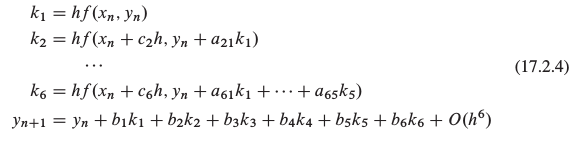

$y_{n+1}$ is fifth-order and contains the fourth-order solution:

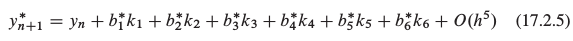

All coefficients are computed so as to ensure the correct integration order:

![lect9fig19.png](rkadaptivetable.png)


This allows us an estimate the error:

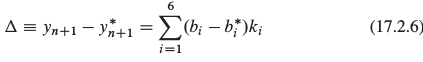

Once we have this, we can obtain an estimate of the **maximum** allowed integration step:

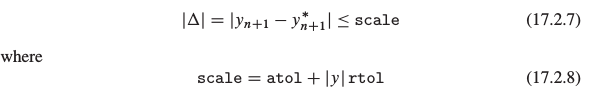

we can define an scaled error as:

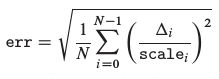

We accept the step if `err`<1. If `err` is **much smaller than one** the we can **increase** the integration step!

There are several methods to evaluate the integration step size given the error scalinw $O(h^5)$, e.g.:

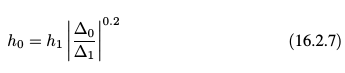

where $\Delta_0$ is the **desired** accuracy, $\Delta_0$ the actual one, and $h_0$, $h_1$ the corresponding integration steps.

<hr>

What follows is a NR implementation of adaptive timesteps runge-kutta 4/5 scheme. **Note that the computaton is in single precision; this should be changed for a professional use**

This solves

$ \frac{dy(x,v_1,v_2.. v_n)}{dx} = f[x,y(x, v_1, v_2... v_n)] $

where you have to put your correct $dy/dx = f(x,y)$. Note you have $N$ dependent variables and one independent variable $x$. 

<hr>

For example the equation for the evolution of the stellar mass depends on the **independent** variable `t` and on no dependent variable. In this case you should however give one to the codes below.
If we added a 1D density **field** for the gas the equation would look like:

$\frac{d\rho_*(t,x)}{dt} = \frac{C_* \rho_g(t,x)}{t_g} $

with several values for $\rho_g$, depending upon its spatial position. In this case one could discretize the gas density field, for example by writing $\rho_g(t,x_i, i=1...N)$. This would take $N$ different values for the gas density (that should be given as initial conditions!). The right-hand member could also include other dipendence upon the dependent variable, e.g $C_*(x_i, i=1...N)$ would allow for a space-dependent star formation efficiency. We could also allow for *spatial gas transfer*, but this would transform the ODE in a PDE.

<hr>

If you want to solve a *system* of $M$ coupled ODE you have to generalize the functions below. In that case you will have to solve:

$ \frac{dy_i(x,v_1,v_2.. v_n)}{dx} = f[x,y_1(x, v_1, v_2... v_n), ..., y_M(x, v_1, v_2... v_n)] $

So you will have to write a functions that gives $dy_1(x,v_{1..N})/dx$, ... , $dy_M(x,v_{1..N})/dx$.

In the example above, coupling the equations for the gas and stellar density distribution:

$\frac{d\rho_*(t,x)}{dt} = \frac{C_* \rho_g(t,x)}{t_g} $

$\frac{d\rho_g(t,x)}{dt} = -\frac{d\rho_*(t,x)}{dt} = -\frac{C_* \rho_g(t,x)}{t_g} $

In this case you should modify `odeint` below, by adding formal parameters for the second equation, e.g. `float z[], float dzdy[]`. Note that the value of the dependent variable is the same for the two functions in this implementation. **Note also that in this case, your supplied function deriv should  take care of computing dydx *and* dzdx.** 

In the example above, with $y=\rho_*$, $z=\rho_g$  :

$ dydx = \frac{d\rho_*(t,x)}{dt} = \frac{C_* \rho_g(t,x)}{t_g}  = \frac{C_* z(t,x)}{t_g}$

$ dzdx = \frac{d\rho_g(t,x)}{dt} = -\frac{C_* \rho_g(t,x)}{t_g}  = \frac{C_* z(t,x)}{t_g}$


In [ ]:
#include <math.h>
#include "nrutil.h"
#define SAFETY 0.9
#define PGROW -0.2
#define PSHRNK -0.25
#define ERRCON 1.89e-4
/*The value ERRCON equals (5/SAFETY) raised to the power (1/PGROW), see use below. */

void rkqs( float y[], float dydx[], int n, float *x, float htry, float eps,
    float yscal[], float *hdid, float *hnext,
    void (*derivs)(float, float [], float []) )
/*
Fifth-order Runge-Kutta step with monitoring of local truncation error to ensure accuracy and
adjust stepsize. 
Input are the   ***dependent variable vector y[1..n]*** and its derivative ***dydx[1..n]***
at the starting value of the independent variable x. 
Also input are the stepsize to be attempted htry, the required accuracy eps, and the vector 
yscal[1..n] against which the error is scaled. 
On output, y and x are replaced by their new values, hdid is the stepsize that was
actually accomplished, and hnext is the estimated next stepsize. derivs is the user-supplied
routine that computes the right-hand side derivatives.

NOTE THAT THIS FUNCTION MAKES ONE TIMESTEP OF THE MAXIMUM ACHIEVABLE DIMENSION given the
accuracy requirements.
*/
{
void rkck(float y[], float dydx[], int n, float x, float h,
float yout[], float yerr[], void (*derivs)(float, float [], float [])); /* CALLED function */
                                                                        /* This is the one that makes
                                                                            the hard work..! */
int i;
float errmax,h,htemp,xnew,*yerr,*ytemp;


yerr=vector(1,n);
ytemp=vector(1,n);
h=htry;                       /* Set stepsize to the initial trial value. */
for (;;) 
    {
        rkck(y,dydx,n,*x,h,ytemp,yerr,derivs); /* Take a step. */
        errmax=0.0                             /* Evaluate accuracy. */
        for (i=1;i<=n;i++) errmax=FMAX(errmax,fabs(yerr[i]/yscal[i]));
        errmax /= eps;                         /* Scale relative to required tolerance. */
        if (errmax <= 1.0) break;              /* Step succeeded. Compute size of next step. */
        htemp=SAFETY*h*pow(errmax,PSHRNK);     /* Truncation error too large, reduce stepsize. */
        h=(h >= 0.0 ? FMAX(htemp,0.1*h) : FMIN(htemp,0.1*h)); /*No more than a factor of 10. */
        xnew=(*x)+h;
        if (xnew == *x) nrerror("stepsize underflow in rkqs");
    }
if (errmax > ERRCON) 
    *hnext=SAFETY*h*pow(errmax,PGROW); /* we can increase the timestep! */
else 
    *hnext=5.0*h;                              /* No more than a factor of 5 increase. */
*x += (*hdid=h);
for (i=1;i<=n;i++) y[i]=ytemp[i];
free_vector(ytemp,1,n);
free_vector(yerr,1,n);
}

In [ ]:
#include "nrutil.h"

void rkck(float y[], float dydx[], int n, float x, float h, float yout[],
    float yerr[], void (*derivs)(float, float [], float []))
/*
Given values for n variables y[1..n] and their derivatives dydx[1..n] known at x, use
the fifth-order Cash-Karp Runge-Kutta method to advance the solution over an interval h
and return the incremented variables as yout[1..n]. Also return an estimate of the local
truncation error in yout using the embedded fourth-order method. The user supplies the routine
derivs(x,y,dydx), which returns derivatives dydx at x.
*/
{
int i;
static float a2=0.2,a3=0.3,a4=0.6,a5=1.0,a6=0.875,b21=0.2,
    b31=3.0/40.0,b32=9.0/40.0,b41=0.3,b42 = -0.9,b43=1.2,
    b51 = -11.0/54.0, b52=2.5,b53 = -70.0/27.0,b54=35.0/27.0,
    b61=1631.0/55296.0,b62=175.0/512.0,b63=575.0/13824.0,
    b64=44275.0/110592.0,b65=253.0/4096.0,c1=37.0/378.0,
    c3=250.0/621.0,c4=125.0/594.0,c6=512.0/1771.0,
    dc5 = -277.00/14336.0;
float dc1=c1-2825.0/27648.0,dc3=c3-18575.0/48384.0,
        dc4=c4-13525.0/55296.0,dc6=c6-0.25;
float *ak2,*ak3,*ak4,*ak5,*ak6,*ytemp;

ak2=vector(1,n);
ak3=vector(1,n);
ak4=vector(1,n);
ak5=vector(1,n);
ak6=vector(1,n);
ytemp=vector(1,n);

for (i=1;i<=n;i++)                       /* First step.*/
    ytemp[i]=y[i]+b21*h*dydx[i];
(*derivs)(x+a2*h,ytemp,ak2);             /* Second step. */
for (i=1;i<=n;i++)
    ytemp[i]=y[i]+h*(b31*dydx[i]+b32*ak2[i]);
(*derivs)(x+a3*h,ytemp,ak3);             /*  Third step. */
for (i=1;i<=n;i++)
    ytemp[i]=y[i]+h*(b41*dydx[i]+b42*ak2[i]+b43*ak3[i]);
(*derivs)(x+a4*h,ytemp,ak4);             /*  Fourth step. */
for (i=1;i<=n;i++)
    ytemp[i]=y[i]+h*(b51*dydx[i]+b52*ak2[i]+b53*ak3[i]+b54*ak4[i]);
(*derivs)(x+a5*h,ytemp,ak5);             /* Fifth step. */
for (i=1;i<=n;i++) 
    ytemp[i]=y[i]+h*(b61*dydx[i]+b62*ak2[i]+b63*ak3[i]+b64*ak4[i]+b65*ak5[i]);
(*derivs)(x+a6*h,ytemp,ak6);             /*  Sixth step. */
for (i=1;i<=n;i++)                       /*  Accumulate increments with proper weights. */
    yout[i]=y[i]+h*(c1*dydx[i]+c3*ak3[i]+c4*ak4[i]+c6*ak6[i]);
for (i=1;i<=n;i++)
    yerr[i]=h*(dc1*dydx[i]+dc3*ak3[i]+dc4*ak4[i]+dc5*ak5[i]+dc6*ak6[i]); 
                                         /* Estimate error as difference between fourth and fifth order methods. */
free_vector(ytemp,1,n);
free_vector(ak6,1,n);
free_vector(ak5,1,n);
free_vector(ak4,1,n);
free_vector(ak3,1,n);
free_vector(ak2,1,n);
}                                        


In [ ]:
#include <math.h>
#include "nrutil.h"
#define MAXSTP 10000
#define TINY 1.0e-30

extern int kmax,kount;               /* NOTE the extern declaration */
extern float *xp,**yp,dxsav;
/* 
User storage for intermediate results. Preset kmax and dxsav in the calling program. 
If kmax != 0 results are stored  at approximate intervals dxsav 
in the arrays xp[1..kount], yp[1..nvar][1..kount], 
where kount is output by odeint . 
Defining declarations for these variables, with memory allocations xp[1..kmax] and yp[1..nvar][1..kmax] f
or the arrays, should be in the calling program.
*/

void odeint( float ystart[], int nvar, float x1, float x2, float eps, float h1,
            float hmin, int *nok, int *nbad,
            void (*derivs)(float, float [], float []),
            void (*rkqs)(float [], float [], int, float *, float, float, float [],
            float *, float *, void (*)(float, float [], float []) ) 
/*
Runge-Kutta driver with adaptive stepsize control. Integrate starting values ystart[1..nvar]
from x1 to x2 with accuracy eps, storing intermediate results in global variables. h1 should
be set as a guessed first stepsize, hmin as the minimum allowed stepsize (can be zero). On
output nok and nbad are the number of good and bad (but retried and fixed) steps taken, and
ystart is replaced by values at the end of the integration interval. 
   derivs is the user-supplied routine for calculating the right-hand side derivative
   rkqs is the name of the stepper routine to be used.
*/
{
 int nstp,i;
 float xsav,x,hnext,hdid,h;
 float *yscal,*y,*dydx;
 yscal=vector(1,nvar);
 y=vector(1,nvar);
 dydx=vector(1,nvar);
 x=x1;
 h=SIGN(h1,x2-x1);
 *nok = (*nbad) = kount = 0;

 for (i=1;i<=nvar;i++) y[i]=ystart[i];
 if (kmax > 0) xsav=x-dxsav*2.0;      /* Assures storage of first step.*/
 for (nstp=1;nstp<=MAXSTP;nstp++)     /*Take at most MAXSTP steps. */
  {
    (*derivs)(x,y,dydx);
    for (i=1;i<=nvar;i++)    /* Scaling used to monitor accuracy. This general-purpose choice */
                             /* can be modified if need be. */
        yscal[i]=fabs(y[i])+fabs(dydx[i]*h)+TINY;
    if (kmax > 0 && kount < kmax-1 && fabs(x-xsav) > fabs(dxsav)) 
        {
          xp[++kount]=x;     /*  Store intermediate results. */
          for (i=1;i<=nvar;i++) yp[i][kount]=y[i];
          xsav=x;
        }
    if ((x+h-x2)*(x+h-x1) > 0.0) h=x2-x; /* If stepsize can overshoot, decrease. */

    (*rkqs)(y,dydx,nvar,&x,h,eps,yscal,&hdid,&hnext,derivs);
    
    if (hdid == h) ++(*nok); else ++(*nbad);
    if ((x-x2)*(x2-x1) >= 0.0)           /* Are we done? */
        {
          for (i=1;i<=nvar;i++) ystart[i]=y[i];
          if (kmax) 
              {
                xp[++kount]=x;           /* Save final step. */
                for (i=1;i<=nvar;i++) yp[i][kount]=y[i];
              }
          free_vector(dydx,1,nvar);
          free_vector(y,1,nvar);
          free_vector(yscal,1,nvar);
          return;                              /*  Normal exit. */
        }
    if (fabs(hnext) <= hmin) nrerror("Step size too small in odeint");
    h=hnext;
  }
nrerror("Too many steps in routine odeint");
}


You have to have `nrutlil.h` that contains some NR utilities. You'll find the above codes and nrutil.h in the git repository.

**BEWARE**. NR in C is translated from NR in fortran. *Arrays indexes start from 1, not from 0*!!!!

<hr>
<hr>

**Exercize 2**: Integrate the evolution of the cosmological scale factor $a(t)$. Let's remember that, given a cosmological model, the evolution of the scale factor is given by the Friedmann-Lemaitre-Robertson-Walker equations:

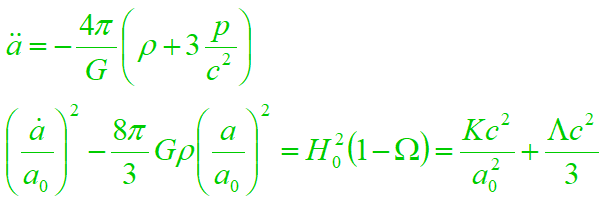

Generalizing the equation for a **Dark Energy** component:

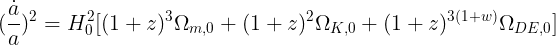

where:

$z$ is the *cosmological redshift* defined by: $1+z=a_0/a$, where $a_0=1$ when $z=0$;

$\Omega_{K,0} = 1 - \Omega_{m,0} - \Omega_{DE,0}$

$\Omega_{m,0}$ and $\Omega_{DE,0}$ are the matter and Dark Energy density parameters at $z=0$.

$H_0$ is the Hubble constant at $z=0$ (use 70 km/s/Mpc; note that this determines the  UdM of the equation);

$w$ gives the equation of state of the Dark Energy, $p = w\rho$: $w= -1$ for a $\Lambda$CDM cosmological model.

Your code should accept all parameters from the command line. 


To integrate $a(t)$, use both your midpoint code, and the above adaptive-timestep routine.
Try a number of different cosmological model; integrate $a(t)$ between $t=0$ and $t=14 Gyr$. Use both codes and try to guess the difference in accuracy/computing time. **Make plots.**

**Exercize 3**: Rewrite the code of Exercize 1 to use adaptive time-steps. Look at differences in accuracy and computing time.
(use the linear and the quadratic law...)

**Exercize 4 (at home)**: try to modify the NR codes to integrate the couples ODE that describe the evolution of the gas AND the stars.

<hr>

**Question**: Would you parallelize these integration methods with OpenMP? When? How?

<hr>

**Question**: Are you interested in half a lesson on PDEs? E.g. solving the diffusion equation.

<hr>

**Final note**. There are **libraries** that contain a number of pre-written numerical functions. A particularly good one is the **GNU Scientific Library** (**GSL**). It contains also an algorithm for RK4/5. Try to download and install the GSL and use **their** functions to repeat exercizes 2,3,4.





## PDEs: a simple method for the diffusion equation

(This part is taked from the online lecture of Brian E. J. Rose, Albany University)

Remember that if a we have $f=f(t,x)$,

$$\frac{df}{dt} = \frac{\partial f}{\partial t} + \frac{\partial x}{\partial t} \frac{\partial f}{\partial x} = \frac{\partial f}{\partial t} + v \frac{\partial f}{\partial x}$$

Thus:
- total and partial time derivatives coincides only if there are no fluxes in x (v=0). 
- when we have those fluxes, differential equations becomes Partial Differential Equations (PDEs) and the spatial variation must be taken into account togheter with the time variation

<hr>
A simple example is the diffusion equation.

Suppose that a quantity u(x) is mixed down-gradient by a diffusive process.
The diffusive flux is

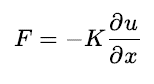

changes in u(x) will be given by:

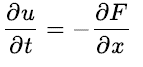

Thus:

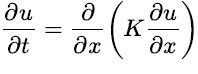

and if K is constant, we get the classical diffusion equation:

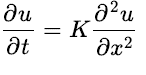

Solving this equation is a tipical initial boundary value problem.


## Discretization of the spatial part

Here we are going to use the **forward Euler method** for this task.

We discretize the spatial part using points $x_j$ and the temporal part with $t^n$ so that

$$ u_j^n = u(t^n, x_j) $$

We approximate the flux using a **centered difference scheme**:

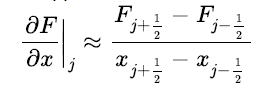

Thus at point $x_j$ we have:

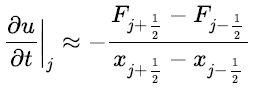


The flux itself depends on a spatial derivative of u . We will apply the same centered difference approximation. At point $x_j$ this would look like

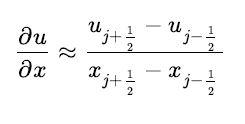

But we actually want to approximate $F_{j-1/2}$ ,  $F_{j+1/2}$ , so we apply the centered difference formula at these intermediate points to get

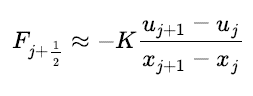

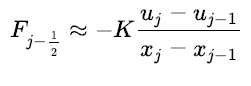

When fluxes are evaluated at the grid boundaries and quantities at the central grid points, the scheme is called **staggered grid**. It can be shown that this scheme is order $O( (\Delta x)^2 )$ in space, with $\Delta x$ being the grid spacing.

In the case of the diffusion equation, we have:

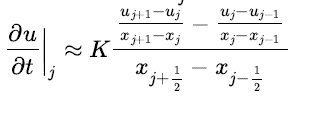

but

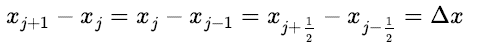

and thus with a bit of algebra, we have:

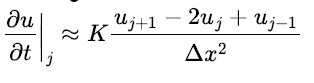

This is the discretization of the diffusion equation. *Note that the truncation error is $O(\Delta x^2)$ for fluxes but $O(\Delta x^3)$ for positions. This is the same kind of truncation error of the leap frog*.

We can now solve the spatial part using directly the staggered grid method, and the temporal parti using a RK4/5 integrator.
Note that the heat equation is identical to this one.


**Exercize 5 (at home)**: Try to solve the diffusion equation. Use a grid of 100 equispaced point in [0,1); as initial condition, set to 1 values of u in the central 10 point and to 0 everywhere else. Note that, dimensionally, K is the square of a length divided by a time. You can use $cm^2 s^{-1}$. try various values and look at the differences.

Note that, being $2^{nd}$ order in space, you will need also boundary conditions for the *fluxes*. Use "wall" boundary conditions, thus $F(0)=F(1)=0$ (no fluxes outside the interval; note that the first point of the grid will be $x_{0}=\Delta x/2$ ). A different boundary could be a periodic boundary condition (how would you write it?)



